### Problem 2:
#### Evacuation modelling

For a 10m x 10m room how long does it take pedestrians to evacuate?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean, variance

In [2]:
# bunch of Anders' stuff from scenario_corridor.ipynb
from world import World, normalise_vector, vector_length, get_nearest_position
import math
import numpy as np


def pedestrian_initialisation(pedestrian, polygons, statistics):
    pass

def update_directions(pedestrians, boundaries, polygons):
    for i, ped in pedestrians.items():
        destination_polygon_centroid = polygons[ped.destination]["nodes"].mean(axis=0)
        ped.desired_direction = normalise_vector(destination_polygon_centroid - ped.pos)

def process_interactions(pedestrians, boundaries, polygons):
    # Parameters
    tau = 0.5
    A_boundary_social, B_boundary_social = .5, 2
    A_boundary_physical = 50
    A_social, B_social = .5, 2
    A_physical = 4
    Lambda = 0.2
    for i, ped_i in pedestrians.items():
        ped_i.acc = (ped_i.desired_walking_speed*ped_i.desired_direction - ped_i.vel) * (1/tau)
        # Pairwise forces from other pedestrians
        for j, ped_j in pedestrians.items():
            if i!=j:
                distance = vector_length(ped_i.pos - ped_j.pos)
                tangent = normalise_vector(ped_i.pos - ped_j.pos)
                # Angular dependency
                vec_ij = normalise_vector(ped_j.pos - ped_i.pos)
                cos_phi = normalise_vector(ped_i.vel).dot(vec_ij)
                angular_dependency = Lambda + (1.0 - Lambda)*((1+cos_phi)/2.0)
                # Apply physical force
                if distance <= ped_i.radius+ped_j.radius:
                    ped_i.acc += A_physical*tangent
                # Apply social force
                if ped_i.group_name == 'group1':
                    ped_i.acc += A_social*angular_dependency*math.exp(-(distance)/B_social)*tangent

                # apply negative (attractive) force if both peds are group 2
                elif ped_i.group_name == 'group1' and ped_j.group_name == 'group2':
                    ped_i.acc -= A_social*angular_dependency*math.exp(-(distance)/B_social)*tangent

        
        # Forces from boundaries
        for boundary in boundaries:
            pos_b  = get_nearest_position(ped_i.pos, boundary)
            distance = vector_length(ped_i.pos - pos_b)
            tangent = normalise_vector(ped_i.pos - pos_b)
            # Apply physical boundary force
            if distance <= ped_i.radius:
                ped_i.acc += A_boundary_physical*tangent
            # Apply social boundary force
            ped_i.acc += A_boundary_social*math.exp(-(distance)/B_boundary_social)*tangent


In [ ]:
# world definition function for dynamic creation
def World_Definition(room_width=10,
                     source_width=2,
                     door_width=2,
                     update_directions=update_directions,
                     process_interactions=process_interactions,
                     pedestrian_initialisation=pedestrian_initialisation):
    
    world_definition = {
        'space': {
            'room': {'type': 'rectangle',
                    'coordinates': [0, 0, room_width, room_width],
                    'colour': 'gray',
                    'add_boundaries': False},
            'origin': {'type': 'rectangle',
                    'coordinates': [0, room_width-source_width, source_width, room_width],
                    'colour': 'green',
                    'add_boundaries': False},
            'destination': {'type': 'rectangle',
                            'coordinates': [room_width+1, (room_width-door_width)/2, room_width+2, (room_width+door_width)/2],
                            'colour': 'red',
                            'add_boundaries': False}
        },
        'pedestrians': {
            'group1': {'source': 'origin',
                    'destination': 'destination',
                    'colour': 'blue',
                    'birth_rate': 5,
                    'max_count': 25}
        },
        # counter clockwise from lower-right corner
        'boundaries': [[room_width, 0, 0, 0],
                    [0, 0, 0, room_width],
                    [0, room_width, room_width, room_width],
                    [room_width, room_width, room_width, (room_width+door_width)/2],
                    [room_width, (room_width-door_width)/2, room_width, 0]],
        'functions': {'update_directions': update_directions,
                    'process_interactions': process_interactions,
                    'pedestrian_initialisation': pedestrian_initialisation
        }
    }

    return world_definition

In [ ]:
room_width = 10     # both width and height
source_width = 2
door_widths = np.linspace(0, 5, num=25)

use_graphics = False

if use_graphics is True:
    # very slow but properly displays the animation in dedicated window
    %matplotlib tk
else:
    %matplotlib widget

worlds = {door: World(World_Definition(door), use_graphics=use_graphics) for door in door_widths}

statistics = []
time = 1200      # dt=0.05, 1 minute=1200 ticks
completed_journeys = {}

for t in range(time):

    # update 3 scenarios
    for door in door_widths:
        worlds[door].update(0.05)

        try:
            completed_journeys[door] = worlds[door].get_statistics()['completed_journeys']
        except KeyError:
            # if no journeys are completed
            pass



    # if t % 25 == 0:
    #     statistics.append({'time': world.time,
    #                     'pedestrians': [{'id': i_ped,
    #                                         'position': ped.pos,
    #                                         'velocity': ped.vel
    #                                         } for i_ped, ped in world.pedestrians.items()]
    #                     })
        # world.render()
    



(-0.5, 10.0)

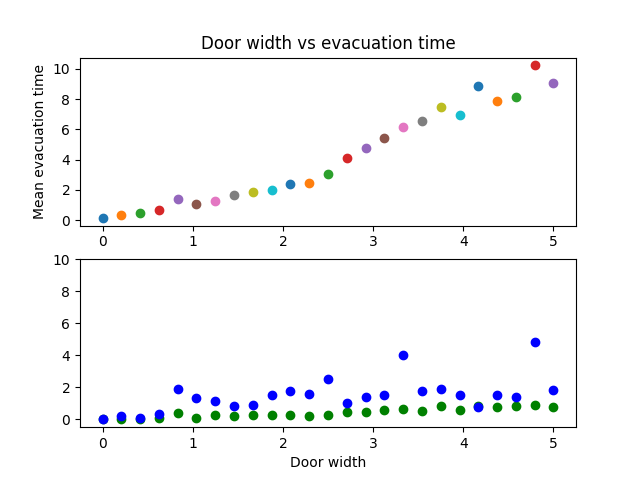

In [8]:
headways_mean = {}
headways_var = {}
for door in door_widths:
    headways_temp = np.asarray(worlds[door].get_statistics()['completed_journeys'])
    headways_mean[door] = mean(np.diff(headways_temp))
    headways_var[door] = variance(np.diff(headways_temp))

fig, ax = plt.subplots(nrows=2)

for door in door_widths:
    ax[0].scatter(door, mean(worlds[door].get_statistics()['completed_journeys']))
    ax[1].scatter(door, headways_mean[door], color='green')
    ax[1].scatter(door, headways_var[door], color='blue')
    # ax[1].scatter(door, headways_var[door]/headways_mean[door], color='red')

ax[1].set_xlabel('Door width')
ax[0].set_ylabel('Mean evacuation time')
ax[0].set_title('Door width vs evacuation time')
ax[1].set_ylim([-0.5, 10])  # door~0.6 has a big outlier that ruins the graph





#### Similar scenario with 2 exits on the east and south walls


In [32]:
# world definition function with 2 exists for dynamic creation
# also has destination be big backwards L in lower right corner
def World_Definition_Double(room_width=10,
                            source_width=2,
                            door_width=2,
                            update_directions=update_directions,
                            process_interactions=process_interactions,
                            pedestrian_initialisation=pedestrian_initialisation):
    
    world_definition = {
        'space': {
            'room': {'type': 'rectangle',
                    'coordinates': [0, 0, room_width, room_width],
                    'colour': 'gray',
                    'add_boundaries': False},
            'origin': {'type': 'rectangle',
                    'coordinates': [0, room_width-source_width, source_width, room_width],
                    'colour': 'green',
                    'add_boundaries': False},
            'destination_right': {'type': 'rectangle',
                                'coordinates': [room_width+1, (room_width-door_width)/2, room_width+2, (room_width+door_width)/2],
                                'colour': 'red',
                                'add_boundaries': False},
            'destination_south': {'type': 'rectangle',
                                  'coordinates': [(room_width-door_width)/2, -2, (room_width+door_width)/2, -1],
                                  'colour': 'red',
                                  'add_boundaries': False}
        },
        'pedestrians': {
            'group_right': {'source': 'origin',
                    'destination': 'destination_right',
                    'colour': 'blue',
                    'birth_rate': 5,
                    'max_count': 10},
            'group_south': {'source': 'origin',
                            'destination': 'destination_south',
                            'colour': 'blue',
                            'birth_rate': 5,
                            'max_count': 10}
        },
        # counter clockwise from lower-right corner
        'boundaries': [[room_width, 0, (room_width+door_width)/2, 0],
                       [(room_width-door_width)/2, 0, 0, 0],
                    [0, 0, 0, room_width],
                    [0, room_width, room_width, room_width],
                    [room_width, room_width, room_width, (room_width+door_width)/2],
                    [room_width, (room_width-door_width)/2, room_width, 0]],
        'functions': {'update_directions': update_directions,
                    'process_interactions': process_interactions,
                    'pedestrian_initialisation': pedestrian_initialisation
        }
    }

    return world_definition

Same as previously, investigating evacuation and headway for different door widths

In [34]:
worlds_double = {door: World(World_Definition_Double(door), use_graphics=use_graphics) for door in door_widths}

statistics = []
time = 1200      # dt=0.05, 1 minute=1200 ticks
completed_journeys_double = {}

for t in range(time):

    # update 3 scenarios
    for door in door_widths:
        worlds_double[door].update(0.05)

        try:
            completed_journeys_double[door] = worlds_double[door].get_statistics()['completed_journeys']
        except KeyError:
            # if no journeys are completed
            pass



In [35]:
headways_mean_double = {}
headways_var_double = {}
for door in door_widths:
    headways_temp = np.asarray(worlds_double[door].get_statistics()['completed_journeys'])
    headways_mean_double[door] = mean(np.diff(headways_temp))
    headways_var_double[door] = variance(np.diff(headways_temp))

fig, ax = plt.subplots(nrows=2)

for door in door_widths:
    ax[0].scatter(door, mean(worlds_double[door].get_statistics()['completed_journeys']))
    ax[1].scatter(door, headways_mean_double[door], color='green')
    ax[1].scatter(door, headways_var_double[door], color='blue')
    # ax[1].scatter(door, headways_var[door]/headways_mean[door], color='red')

ax[1].set_xlabel('Door width')
ax[0].set_ylabel('Mean evacuation time')
ax[0].set_title('Door width vs evacuation time')
ax[1].set_ylim([-0.5, 10])  # door~0.6 has a big outlier that ruins the graph

(-0.5, 10.0)